C:\Users\manoj\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\manoj\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


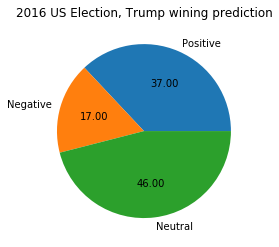

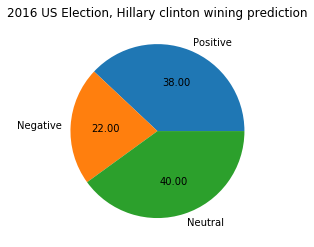

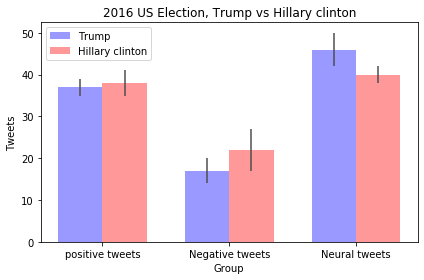

In [3]:
import re
from textblob import TextBlob
import base64
import requests
import matplotlib.pyplot as plt
import numpy as np


def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w+:\ / \ / \S+)", " ", tweet).split())


def get_tweet_sentiment(tweet):
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'


def get_tweets(access_token, base_url, searchTerm):
    search_headers = {
        'Authorization': 'Bearer {}'.format(access_token)
    }
    search_params = {
        'query': searchTerm,  # Key word to search in user's tweets
        'fromDate': '201409200000',
        'toDate': '201610300000'
    }
    search_url = '{}1.1/tweets/search/fullarchive/Fulltweet.json'.format(base_url)
    search_response = requests.get(search_url, headers=search_headers, params=search_params)
    search_data = search_response.json()
    return search_data['results']


def get_parsed_tweet(fetched_tweets):
    # empty array to store praised tweets
    tweets = []
    for tweet in fetched_tweets:
        # empty dictionary to store required params of a tweet
        parsed_tweet = {}

        # saving text of tweet
        parsed_tweet['text'] = tweet['text']
        # saving sentiment of tweet
        parsed_tweet['sentiment'] = get_tweet_sentiment(tweet['text'])

        # appending parsed tweet to tweets list
        if tweet['retweet_count'] > 0:
            # if tweet has retweets, ensure that it is appended only once
            if parsed_tweet not in tweets:
                tweets.append(parsed_tweet)
        else:
            tweets.append(parsed_tweet)
    return tweets


def main():
    # Keys from twitter developer account 'Simarpal singh'
    # consumer_key = "6xBBCEPMnPspyu326TpmkzCGN"
    # consumer_secret = "MxvbtzHp5Q8eELG4bbluq4IbHjk3kcqmVJUuu7dzilJA6TyfRt"

    consumer_key = "PrxzTb7xbYVfd6Ns2ty2jMpJT"
    consumer_secret = "cvnPYT30rrCaMnTX4wTPkqM9jupOTqLjT9HMBMm4HnRb6Kb3Fx"

    # Ouath2 authentication
    key_secret = '{}:{}'.format(consumer_key, consumer_secret).encode('ascii')
    b64_encoded_key = base64.b64encode(key_secret)
    b64_encoded_key = b64_encoded_key.decode('ascii')
    base_url = 'https://api.twitter.com/'
    auth_url = '{}oauth2/token'.format(base_url)
    auth_headers = {
        'Authorization': 'Basic {}'.format(b64_encoded_key),
        'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
    }
    auth_data = {
        'grant_type': 'client_credentials'
    }
    auth_response = requests.post(auth_url, headers=auth_headers, data=auth_data)
    # Key in auth_response is access_token (our access token)
    access_token = auth_response.json()['access_token']

    # Searched tweets for Trump
    fetched_trump_tweets = get_tweets(access_token, base_url, "@realDonaldTrump")
    # Searched tweets for hillary clinton
    fetched_hillaryClinton_tweets = get_tweets(access_token, base_url, "@HillaryClinton")

    # Praised tweets containing sentiment of tweet
    trump_tweets = get_parsed_tweet(fetched_trump_tweets)
    hillaryClinton_tweets = get_parsed_tweet(fetched_hillaryClinton_tweets)

    # picking positive trump tweets from trump_tweets
    positive_trump_tweets = [tweet for tweet in trump_tweets if tweet['sentiment'] == 'positive']
    # picking negative trump tweets from trump_tweets
    negative_trump_tweets = [tweet for tweet in trump_tweets if tweet['sentiment'] == 'negative']

    # picking positive hillary clinton tweets from hillaryClinton_tweets
    positive_hillaryClinton_tweets = [tweet for tweet in hillaryClinton_tweets if tweet['sentiment'] == 'positive']
    # picking negative hillary clinton tweets from hillaryClinton_tweets
    negative_hillaryClinton_tweets = [tweet for tweet in hillaryClinton_tweets if tweet['sentiment'] == 'negative']

    # Prepare Trump pie chart
    sizes = [len(positive_trump_tweets), len(negative_trump_tweets),
             (len(trump_tweets) - len(negative_trump_tweets) - len(positive_trump_tweets))]
    labels = ["Positive", "Negative", "Neutral"]
    plt.figure(1)
    plt.title('2016 US Election, Trump wining prediction')
    plt.pie(sizes, labels=labels, autopct="%.2f")
    plt.axes().set_aspect("equal")

    # Prepare Hillary clinton pie chart
    sizes = [len(positive_hillaryClinton_tweets), len(negative_hillaryClinton_tweets),
             (len(hillaryClinton_tweets) - len(negative_hillaryClinton_tweets) - len(positive_hillaryClinton_tweets))]
    labels = ["Positive", "Negative", "Neutral"]
    plt.figure(2)
    plt.title('2016 US Election, Hillary clinton wining prediction')
    plt.pie(sizes, labels=labels, autopct="%.2f")
    plt.axes().set_aspect("equal")

    # Prepare Trump vs Hillary clinton bar chart
    n_groups = 3
    means_men = (len(positive_trump_tweets), len(negative_trump_tweets),
                 (len(trump_tweets) - len(negative_trump_tweets) - len(positive_trump_tweets)))
    std_men = (2, 3, 4)
    means_women = (len(positive_hillaryClinton_tweets), len(negative_hillaryClinton_tweets), (
                len(hillaryClinton_tweets) - len(negative_hillaryClinton_tweets) - len(positive_hillaryClinton_tweets)))
    std_women = (3, 5, 2)
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    rects1 = ax.bar(index, means_men, bar_width,
                    alpha=opacity, color='b',
                    yerr=std_men, error_kw=error_config,
                    label='Trump')
    rects2 = ax.bar(index + bar_width, means_women, bar_width,
                    alpha=opacity, color='r',
                    yerr=std_women, error_kw=error_config,
                    label='Hillary clinton')
    ax.set_xlabel('Group')
    ax.set_ylabel('Tweets')
    ax.set_title('2016 US Election, Trump vs Hillary clinton')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('positive tweets', 'Negative tweets', 'Neural tweets'))
    ax.legend()
    fig.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()